In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from mvo_utils_v3 import *
from workspace import OptWorkspace

In [18]:
sel_universe = "bw-aclasses"
lookback = 252
net_exposure, leverage = 0, 1
min_exp, max_exp = -0.25, 0.25
historical = 252 * 10
opt_env = OptWorkspace(
    lookback, net_exposure, leverage, min_exp, max_exp, 
    universe=sel_universe, etfOnly=True, historicWindow=historical)
opt_env.refreshPricing = False
opt_env.print_global_vars()

Global Variables
Refresh Pricing: True
Historical Time Window: 2520
Lookback: 252
Rebalance Frequency: W-Fri
Net Exposure: 0
Leverage: 1
Weights: min -0.25 to max 0.25
Universe: bw-aclasses



In [19]:
if opt_env.refreshPricing:
    opt_env.refresh_sector_px();
    opt_env.get_pricing('SPY.csv', ['SPY']);

Getting pricing for: bw-aclasses.csv 2011-05-27
[*********************100%***********************]  12 of 12 downloaded
Getting pricing for: SPY.csv 2011-05-27
[*********************100%***********************]  1 of 1 downloaded


In [20]:
consol_px = opt_env.load_px()
px_spy = opt_env.load_px('SPY.csv')
corr_mtx = compound(consol_px).corr()
# sns.heatmap(corr_mtx)
corr_mtx

Loaded pricing for bw-aclasses.csv, with shape (1736, 12)
Loaded pricing for SPY.csv, with shape (1736, 1)


,BIL,DJCI,EMB,IAU,IBND,IWM,SPY,TIP,VEA,VGIT,VGLT,VWO
BIL,1.000000,0.099620,0.257283,0.302831,0.369319,0.242415,0.232365,0.242119,0.313826,-0.068048,-0.043046,0.714190
DJCI,0.099620,1.000000,-0.801938,0.787065,0.150677,-0.817115,-0.870592,-0.362220,-0.670745,-0.919840,-0.868992,-0.114465
EMB,0.257283,-0.801938,1.000000,-0.520033,0.177493,0.882065,0.917079,0.710136,0.803918,0.885539,0.837781,0.545995
IAU,0.302831,0.787065,-0.520033,1.000000,-0.094015,-0.748893,-0.738929,0.044339,-0.704312,-0.590104,-0.501805,-0.060961
IBND,0.369319,0.150677,0.177493,-0.094015,1.000000,0.267296,0.213759,0.061514,0.483880,-0.099713,-0.166348,0.521994
IWM,0.242415,-0.817115,0.882065,-0.748893,0.267296,1.000000,0.986404,0.371725,0.951505,0.746727,0.669008,0.573781
SPY,0.232365,-0.870592,0.917079,-0.738929,0.213759,0.986404,1.000000,0.421814,0.924959,0.816767,0.753712,0.535689
TIP,0.242119,-0.362220,0.710136,0.044339,0.061514,0.371725,0.421814,1.000000,0.290370,0.640855,0.663010,0.365265
VEA,0.313826,-0.670745,0.803918,-0.704312,0.483880,0.951505,0.924959,0.290370,1.000000,0.601635,0.513884,0.690597
VGIT,-0.068048,-0.919840,0.885539,-0.590104,-0.099713,0.746727,0.816767,0.640855,0.601635,1.000000,0.971382,0.161174


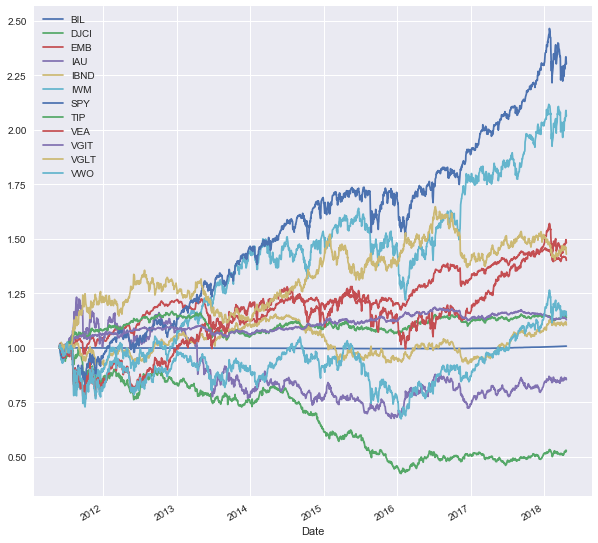

In [21]:
compound(consol_px).plot(figsize=(10,10));

In [22]:
nes = [float(str(n)[:3]) for n in np.arange(0, 1.01, 0.1)]
ports = pd.DataFrame([], columns=consol_px.columns, index=nes)
metrics = pd.DataFrame([], columns=['Ret','Risk', 'SR'], index=nes)
gamma_val = 2

for i, ne in enumerate(nes):
    opt_env.netExposure = ne
    # gamma_val, gamma_sr = opt_env.quick_gamma(opt_env.gammaVals, consol_px)
    px_portion, returns, alloc, pdf = opt_env.ls_recommend_allocs(consol_px, gamma_val)
    alloc = filter_ls(alloc, 0.01)
    ret, risk = port_metrics(consol_px[-opt_env.lookback:], alloc)
    alloc.columns = [ne]
    ports = ports.combine_first(alloc.T)
    metrics.loc[ne] = [ret, risk, ret / risk]
ports.fillna(0, inplace=True)
metrics = metrics.astype(np.float)

In [23]:
ports.round(2)

,BIL,DJCI,EMB,IAU,IBND,IWM,SPY,TIP,VEA,VGIT,VGLT,VWO
0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.25,-0.25,-0.25,0.25
0.1,0.0,0.0,0.0,0.0,0.05,0.0,0.00,0.0,0.25,-0.25,-0.20,0.25
0.2,0.0,0.0,0.0,0.0,0.10,0.0,0.00,0.0,0.25,-0.25,-0.15,0.25
0.3,0.0,0.0,0.0,0.0,0.15,0.0,0.00,0.0,0.25,-0.25,-0.10,0.25
0.4,0.0,0.0,0.0,0.0,0.20,0.0,0.00,0.0,0.25,-0.25,-0.05,0.25
0.5,0.0,0.0,0.0,0.0,0.25,0.0,0.00,0.0,0.25,-0.25,0.00,0.25
0.6,0.0,0.0,0.0,0.0,0.25,0.0,0.05,0.0,0.25,-0.20,0.00,0.25
0.7,0.0,0.0,0.0,0.0,0.25,0.0,0.10,0.0,0.25,-0.15,0.00,0.25
0.8,0.0,0.0,0.0,0.0,0.25,0.0,0.15,0.0,0.25,-0.10,0.00,0.25
0.9,0.0,0.0,0.0,0.0,0.25,0.0,0.20,0.0,0.25,-0.05,0.00,0.25


In [24]:
metrics.sort_values(by='SR', ascending=False).round(2)

,Ret,Risk,SR
0.5,0.13,0.07,1.90
0.6,0.14,0.07,1.87
0.7,0.14,0.08,1.84
0.4,0.12,0.07,1.83
0.8,0.15,0.08,1.81
0.9,0.16,0.09,1.79
1.0,0.16,0.09,1.76
0.3,0.12,0.07,1.74
0.2,0.11,0.07,1.63
0.1,0.11,0.07,1.51


In [25]:
opt_env.netExposure = metrics['SR'].idxmax()

In [26]:
# gamma_val, gamma_sr = opt_env.quick_gamma(opt_env.gammaVals, consol_px)
px_portion, returns, alloc, pdf = opt_env.ls_recommend_allocs(consol_px, gamma_val)
alloc = filter_ls(alloc, 0.01)
recommend = alloc.copy()
tickers = recommend.index.tolist()
recommend.T.round(2)

,IBND,VEA,VGIT,VWO
Allocation,0.25,0.25,-0.25,0.25


In [27]:
# selected portfolio returns
port_metrics(consol_px[-opt_env.lookback:], alloc)

(0.13027726905516301, 0.06844956619834483)

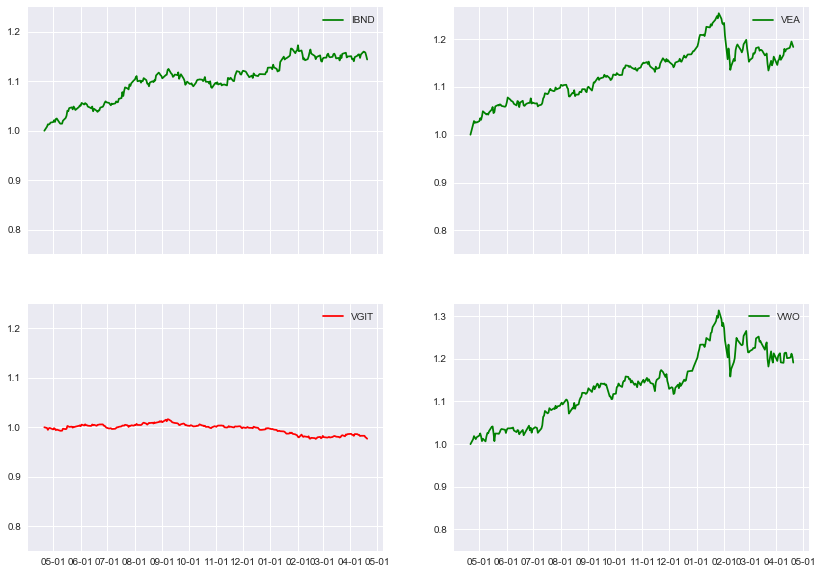

In [28]:
plot_chart_grid(consol_px, recommend, 'Allocation', opt_env.lookback, tickers, cols=int(len(alloc)/2))

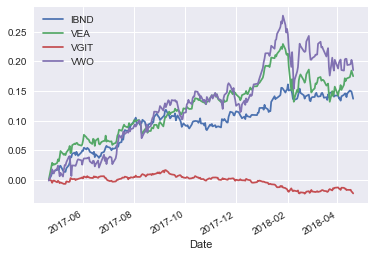

In [29]:
port_idx = compound(consol_px)[alloc.T.columns]
weights = alloc.astype(np.float)
# return attribution analysis
attr = (weights.T.values * port_idx).pct_change().fillna(0)
attr[-opt_env.lookback:].cumsum().plot()

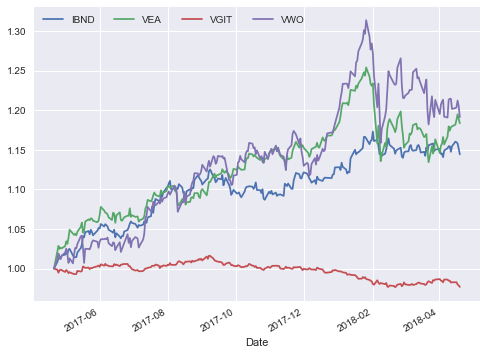

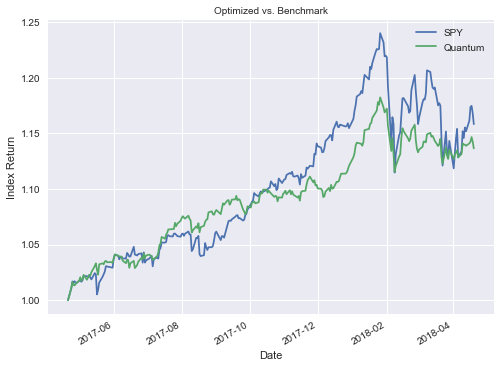

In [30]:
port_pos_idx = compound(consol_px[-opt_env.lookback:][recommend.index])
fig = (8,6)
ax = port_pos_idx.plot(fontsize='small', figsize=fig)
ax.legend(fontsize='small', ncol=4)
idx_px_spy = compound(px_spy.loc[port_pos_idx.index])
plot_two_series(idx_px_spy, pdf, 'SPY', 'Quantum', 'Date', 'Index Return', 'Optimized vs. Benchmark', fig)

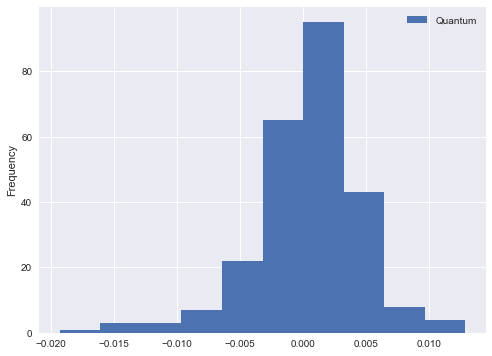

In [31]:
pdf.pct_change().plot(kind='hist', figsize=(8,6), fontsize='small')

In [32]:
# Outputs for trade execution
trading_df = get_sector_trading(220000, consol_px, tickers, opt_env.lookback, alloc)
pprint.pprint(summary_stats(consol_px, tickers, opt_env.lookback, alloc, recommend, trading_df))
if opt_env.refreshPricing: opt_env.save_recommendation(trading_df)    
trading_df.sort_values(by='Allocation', ascending=False)

{'Date': '2018-04-20',
 'Long': 3,
 'Long Exposure': 0.7499995952533608,
 'Net Dollar Exposure': 109998,
 'Positions': 4,
 'Return (Ann)': 0.13027726905516301,
 'Risk (Vol)': 0.06844956619834483,
 'Sharpe Ratio': 1.9032592358242473,
 'Short': 1,
 'Short Exposure': -0.24999991115404907,
 'Total Allocation': 49.99996840993117}
Saved portfolio rebalance: ./recommendations/portrec_bw-aclasses_2018-04-20_18-59.csv


,Price,Allocation,Dollar Value,Shares
VWO,46.139999,0.25,54999,1192
VEA,45.020000,0.25,54999,1221
IBND,35.799999,0.25,54999,1536
VGIT,62.279999,-0.25,-54999,-883
